>Алексей, приветствую! Меня зовут Кудрявцев Александр и я буду проверять твой проект :)
>
>Ниже в ноутбуке будут мои комментарии, закодированные разными цветами.
>
>**_<span style="color:green">Зеленым будут выделены места, которые хочется особенно отметить, как хорошие. </span>_**
>
> **_<span style="color:red">Недочеты, откомментированные красным обязательны к доработке – без их исправления проект не будет зачтен. </span>_**
>  
> **_<span style="color:orange">Недочеты и подсказки, откомментированные оранжевым, учесть желательно, но их доработка не является обязательным условнием для зачета.</span>_**
>
> Если какие-то подзадачи не откомментированны – значит с ними все окей, нет возражений.
>
> Если ошибка влечет за собой дальнейшие неточности рассчетов или выводов – пожалуйста, поправь их тоже, чтобы аналитический отчет был целостным.
>
>Пожалуйста, не удаляй и не переноси мои комментарии, это позволит лучше ориентироваться при возможных повторных проверках.

# Определение перспективного тарифа

## Введение

В наличии выборка 500 пользователей сотовой связи. Проанализируем их потребности в звонках, интернете и сообщениях и как эти потребности изменяются в течении всего года. Попробуем понять какой из двух тарифов приносит больше денег и куда стоит распределить рекламный бюджет.

In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
our_figsize = (15,4)

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

## Подготовка данных

### Оценка данных пользователей

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


Данные полные. Всего 38 пользователей ушло от нас за год. Приведем дату регистрации и дату ухода на pd.Datetime.

In [5]:
users = users.assign(reg_date = lambda x: pd.to_datetime(x.reg_date, format='%Y-%m-%d'),
                    churn_date = lambda x: pd.to_datetime(x.churn_date, format='%Y-%m-%d'))

Оценим колонку с возрастом на артефакты.

In [6]:
users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [7]:
users.duplicated().sum()

0

Выбросов в возрасте не наблюдается и дубликаты не найдены. Переходим к следующей таблице.

### Оценка данных по сообщениям

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
messages.head(2)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


In [10]:
messages = messages.assign(message_date = lambda x: pd.to_datetime(x.message_date, format='%Y-%m-%d'),
                            month_id = pd.DatetimeIndex(messages.message_date).month)

In [11]:
messages.duplicated().sum()

0

Данные без пропусков и дубликатов. Перевели дату к формату pd.Datetime и сделали новую колонку с номером месяца сообщения.

### Оценка данных по интернету

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [13]:
internet.head(2)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


При выгрузке получилось задвоения индексов. Уберем ненужную колонку, время сессии приведем к формату pd.Datetime. Месяц в который сессия проходила выделим в отдельную колонку и округлим количество мегабайтов до ближайшего большего целого, т.к. компания тарифицирует трафик вверх. Также оценим информацию по затраченному трафику.

In [14]:
internet = internet.drop('Unnamed: 0', axis=1)

In [15]:
internet = internet.assign(session_date = lambda x: pd.to_datetime(x.session_date, format='%Y-%m-%d'),
                          month_id = pd.DatetimeIndex(internet.session_date).month,
                          mb_used = internet.mb_used.apply(math.ceil).astype('int'))

In [16]:
internet.duplicated().sum()

0

In [17]:
internet.mb_used.describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

Выбросов и дубликатов не наблюдается.

### Оценка данных по звонкам

In [18]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [19]:
calls.head(2)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


Также изменим тип даты звонка. Продолжительность округлим до ближайшего целого и выделим месяц в который произошел звонок в отдельный столбец.

In [20]:
calls = calls.assign(call_date = lambda x: pd.to_datetime(x.call_date, format='%Y-%m-%d'),
                    month_id = pd.DatetimeIndex(calls.call_date).month,
                    duration = calls.duration.apply(math.ceil).astype('int'))


>**_<span style="color:green">Красивое решение с примением функции `assign`. Так держать! :) </span>_**


In [21]:
calls.duplicated().sum()

0

In [22]:
calls.duration.describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

Дубликатов и выбросов нет. 


>**_<span style="color:green">Здесь всё структурировано и по делу, молодец!</span>_**
>


### Оценка тарифов

In [23]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Вычисления

Создадим две пустые таблицы. В первой будет содержаться все пользователи и их тарифы, вторая будет содержать номер месяца.

In [24]:
df = pd.DataFrame(users[['tariff', 'user_id']])
months = pd.DataFrame([i for i in range(1, 13)], columns=['month_id'])

Проведем cross join этих таблиц. Теперь каждому пользователю соответствует 12 месяцев. В сумме 6000 строк.

In [25]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

df = cartesian_product_basic(df, months)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 3 columns):
tariff      6000 non-null object
user_id     6000 non-null int64
month_id    6000 non-null int64
dtypes: int64(2), object(1)
memory usage: 187.5+ KB


Присоеденим к получившейся таблице информацию по количеству сообщений в каждый месяц.

In [26]:
df = df.join(messages
             .pivot_table(index=['user_id', 'month_id'], aggfunc={'id' : 'count'})
             .rename(columns={'id' : 'messages_number'}), 
             on=['user_id', 'month_id'])

Присоеденим количество трафика по каждому пользователю в месяц.

In [27]:
df = df.join(internet
        .pivot_table(index=['user_id', 'month_id'], aggfunc={'mb_used' : 'sum'}),
        on=['user_id', 'month_id'])

Присоеденим количество и продолжительность звонков по каждому пользователю и месяцу.

In [28]:
df = df.join(calls
        .query('duration != 0')
        .pivot_table(index=['user_id', 'month_id'], aggfunc={'duration' : 'sum', 'id' : 'count'})
        .rename(columns={'duration' : 'calls_duration', 'id' : 'calls_count'}),
        on=['user_id', 'month_id'])

Переводим мегабайты в гигабайты и округляем в большую сторону. Т.к. цена сверх тарифа указана для гигабайтов, делаю предположение, что тарификация также округляет до гигабайтов.

In [29]:
df.mb_used = df.mb_used.apply(lambda x: x / 1024).round()
df = df.rename(columns={'mb_used' : 'gb_used'})

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 7 columns):
tariff             6000 non-null object
user_id            6000 non-null int64
month_id           6000 non-null int64
messages_number    2717 non-null float64
gb_used            3203 non-null float64
calls_duration     3168 non-null float64
calls_count        3168 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 375.0+ KB



>**_<span style="color:green">По агрегации данных и объединению таблиц у тебя полный порядок. Молодец что используешь таблицу с "календарем" для объединения таблиц. Это позволило тебе учесть всех пользователей, даже если они не пользовались какой-либо из услуг в рамках одного месяца. Напрмер, пользователь может пользоваться планшетом - не совершать звонки, но при этом активно использовать интернет и т.п. </span>_**


В данных есть пропуски и это логично. Месяц подключения у всех пользователей разный. Соответственно в такие месяцы у пользователя нет отправленных сообщений, звонков и какого-либо трафика. Также есть месяцы когда человек мог пользоваться только интернето и не отправить ни одного сообщения или не совершить ни одного звонка и т.п.
Напишем функцию для определения выручки на основе имеющихся данных.

In [31]:
def revenue(row):
    #заводим переменную с выручкой
    total_revenue = 0
    #подтягиваем данные о пользователе
    user_fast_info = users.query('user_id == @row.user_id')
    #смотрим на месяц переданной строки, если этот месяц меньше чем дата подключения или больше чем дата отключения
    #сразу возвращаем ноль. 
    if row.month_id < pd.DatetimeIndex(user_fast_info.reg_date).month:
        return total_revenue
    if row.month_id > pd.DatetimeIndex(user_fast_info.churn_date).month:
        return total_revenue
    #выясняем на каком тарифе наш пользователь
    user_tariff = row.tariff
    #подтягиваем информацию по тарифу
    tariff_info = tariffs.query('tariff_name == @user_tariff')
    #считаем надбавленную выручку
    add_messages = float((row.messages_number - tariff_info.messages_included) * tariff_info.rub_per_message)
    add_duration = float((row.calls_duration - tariff_info.minutes_included) * tariff_info.rub_per_minute)
    add_gb = float((row.gb_used - (tariff_info.mb_per_month_included / 1024)) * tariff_info.rub_per_gb)
    #добавляем ежемесячную плату
    total_revenue += float(tariff_info.rub_monthly_fee)
    #если пользователь превысил лимиты, то дополнительная плата будет положительнаяя, проверяем это и плюсуем
    for i in [add_messages, add_duration, add_gb]:
        if i > 0:
            total_revenue += i
    return total_revenue    

Применим функцию расчета выручки. К сожалению функция работает долго, я так подозреваю из-за того, что я задействовал внешние таблицы и каждый раз идет загрузка информации от них.

In [32]:
df = df.assign(
    revenue = lambda x: x.apply(revenue, axis=1))

Пример строк из получившейся таблицы.

In [33]:
df.sample(5)

,tariff,user_id,month_id,messages_number,gb_used,calls_duration,calls_count,revenue
1636,smart,1136,5,NaN,NaN,NaN,NaN,0.0
5557,ultra,1463,2,NaN,NaN,NaN,NaN,0.0
4144,smart,1345,5,NaN,NaN,NaN,NaN,0.0
227,ultra,1018,12,37.0,5.0,839.0,96.0,1950.0
251,smart,1020,12,9.0,9.0,340.0,38.0,550.0



>**_<span style="color:green">Красивое решение с функцией строк для подсчёта выручки. Класс! </span>_**
>


## Анализ данных

Напишем функцию для построения графиков сравнения параметров двух тарифов.

In [34]:
def compare_plot(df, col_name, func='mean', ylabel=None, xlabel='Месяц', title=None):
    month_name = {1 : 'Январь', 2 : 'Февраль', 3 : 'Март', 4 : 'Апрель', 5 : 'Май', 6 : 'Июнь', 7 : 'Июль', 8 : 'Август', 
              9 : 'Сентябрь', 10 : 'Октябрь', 11 : 'Ноябрь', 12 : 'Декабрь'}
    temp = (
        df
        .pivot_table(index=['tariff', 'month_id'], aggfunc={col_name : func})
        .reset_index()
        .replace({'month_id' : month_name}))
    plt.figure(figsize=our_figsize)
    sns.set_style('whitegrid')
    ax = sns.barplot(data=temp, x='month_id', y=col_name, hue='tariff', palette='deep')
    ax.set(ylabel=ylabel, xlabel=xlabel, title=title)
    ax.legend(title='Тариф')
    plt.show()

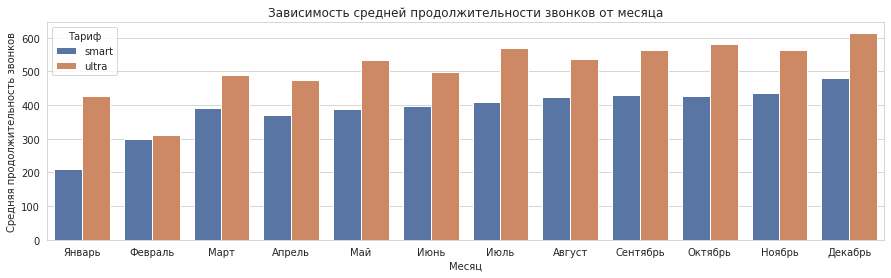

In [35]:
compare_plot(df, 'calls_duration', ylabel='Средняя продолжительность звонков', 
             title='Зависимость средней продолжительности звонков от месяца')

Средняя продолжительность звонков у пользователей тарифа "Смарт" всегда меньше пакетных 500 минут. А вот пользователи тарифа ультра даже близко не подбираются к лимиту по звонкам, хотя в среднем разговаривают дольше чем люди на другом тарифе. Интересно, что в январе у пользователей Ультры просадка намного меньше чем у Смарта. Возможно это связано с новогодними каникулами и структурой занятости среди пользователей тарифа.

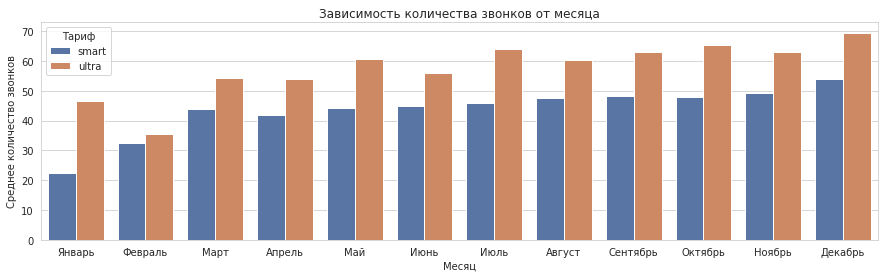

In [36]:
compare_plot(df, 'calls_count', ylabel='Среднее количество звонков', 
             title='Зависимость количества звонков от месяца')

На графиках видно, что количество звонков очень хорошо коррелирует со средней продолжительностью. Раз наблюдается такая корреляция значит растет именно количество звонков, когда средняя продолжительность одного звонка остается на одном уровне.

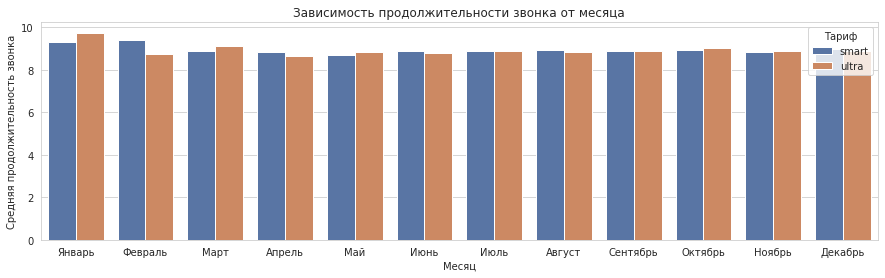

In [37]:
sample = df[['tariff', 'month_id']]
sample = sample.assign(call_dur=df['calls_duration'] / df['calls_count'])
compare_plot(sample, 'call_dur', ylabel='Средняя продолжительность звонка', 
             title='Зависимость продолжительности звонка от месяца')

Рост количества звонков можем объяснить ростом количества пользователей. Оценим как менялось количество пользователей со временем.

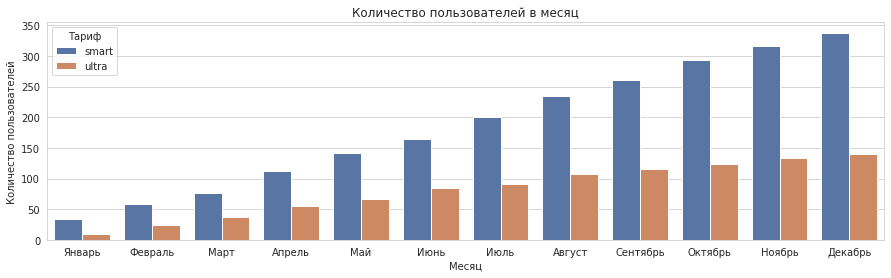

In [38]:
sample = df[['tariff', 'month_id', 'revenue']]
sample = sample.query('revenue > 0')
compare_plot(sample, 'revenue', func='count', ylabel='Количество пользователей', 
             title='Количество пользователей в месяц')

Действительно продолжительность звонка не меняется. Значит прирост продолжительности и количества звонков объясняется притоком новых пользователей в течении года. Верно для обоих тарифов.

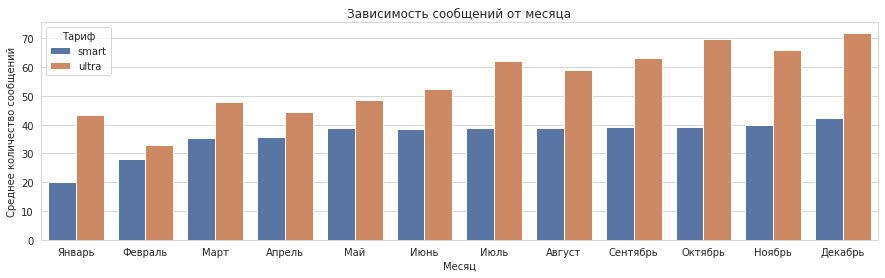

In [39]:
compare_plot(df, 'messages_number', ylabel='Среднее количество сообщений', 
             title='Зависимость сообщений от месяца')

В сообщениях картина аналогична звонкам. Но в данном случае ни одна из груп не приближается к тарифным значениям. Это можно объяснить старостью технологии. Сейчас сообщения используются в основном для взаимодействия с сервисами и для подтверждения номера. В общении это редкость.

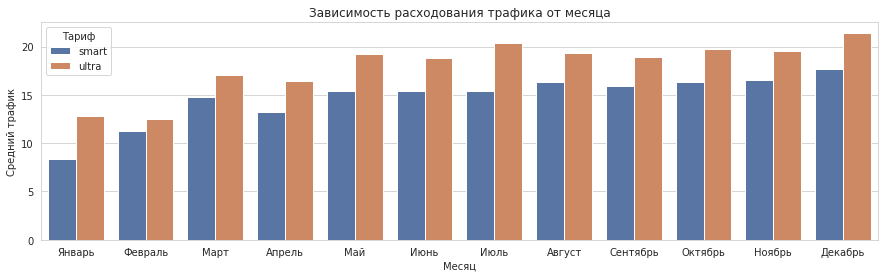

In [40]:
compare_plot(df, 'gb_used', ylabel='Средний трафик', 
             title='Зависимость расходования трафика от месяца')

Пользователи Смарта редко превышают тарифный лимит трафика, но практически всегда выбирают его на полную. А вот пользователи Ультры и в этом случае оказываются далеки от тарифных значений. Это значит, что дополнительных денег с пользователей Ультры компания получает мало. 

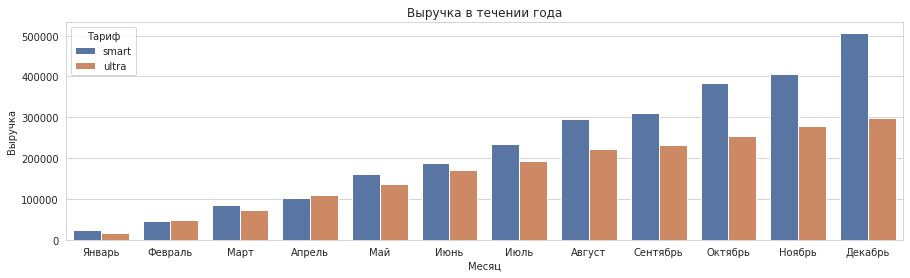

In [41]:
compare_plot(df, 'revenue', func='sum', ylabel='Выручка', 
             title='Выручка в течении года')

Выручка в течении года растет, что не может не радовать. По графику видно, что больше приносят пользователи Смарта. Возможно ли получить такую разность случайно проверим в следующих разделах.
Теперь оценим как рспределен данные величины в зависимости от тарифа. Напишем функцию для оценки и построения графика.

In [42]:
def compare_dist(df, column, xlabel=None, title=None):
    temp1 = df[df['tariff'] == 'ultra'][column]
    temp2 = df[df['tariff'] == 'smart'][column]
    temp1_mean = temp1.mean()
    temp2_mean = temp2.mean()
    temp1_var = np.var(temp1, ddof=1)
    temp2_var = np.var(temp2, ddof=1)
    temp1_std = np.std(temp1, ddof=1)
    temp2_std = np.std(temp2, ddof=1)
    temp1_legend = 'Тариф: Ультра\nСреднее: {:.2f}\nДисперсия {:.2f}\nСтандартное отклонение: {:.2f}'.format(temp1_mean, 
                                                                                                temp1_var, 
                                                                                                temp1_std)
    temp2_legend = 'Тариф: Смарт\nСреднее: {:.2f}\nДисперсия {:.2f}\nСтандартное отклонение: {:.2f}'.format(temp2_mean, 
                                                                                                temp2_var, 
                                                                                                temp2_std)
    temp1 = temp1[temp1.notnull()]
    temp2 = temp2[temp2.notnull()]
    plt.figure(figsize=our_figsize)
    sns.distplot(temp1, label=temp1_legend)
    ax = sns.distplot(temp2, label=temp2_legend)
    plt.xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontdict={'fontsize': 16})
    plt.legend(fontsize='large')
    plt.show()

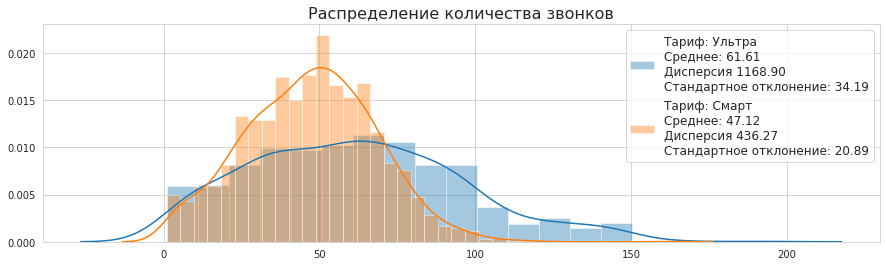

In [43]:
compare_dist(df, 'calls_count', title='Распределение количества звонков')

В среднем пользователи Ультры совершают больше звонков. Большая дисперсия говорит, что среди пользователей Ультры есть те кто совершают намного большее среднего количество звонков, в отличие от пользователей Смарта. Обе характеристики распределны нормально.

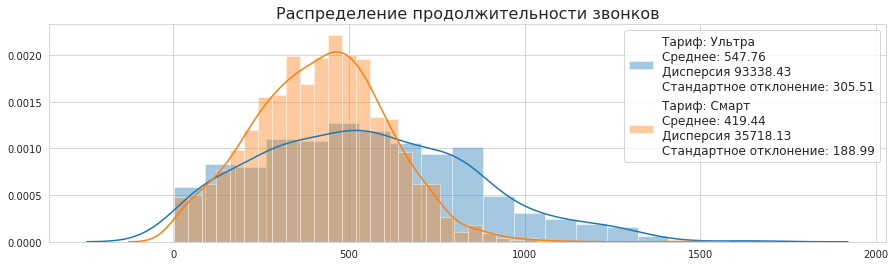

In [44]:
compare_dist(df, 'calls_duration', title='Распределение продолжительности звонков')

Продолжительность звонков как было выясено выше хорошо коррелирует с количеством. Графики получились практически идентичными. Средняя продолжительнось разговора у пользователей Ультры больше. Но разница гораздо меньше чем разница тарифных значений. Средние меньше тарфиных значений, что говорит о том, что компания редко получает доходы сверх абонентской платы.

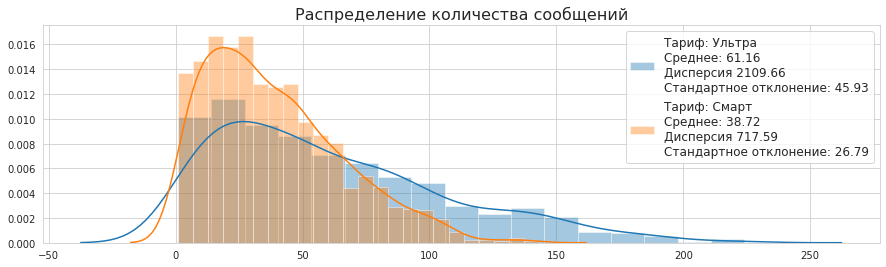

In [45]:
compare_dist(df, 'messages_number', title='Распределение количества сообщений')

Здесь распрделение больше похоже на распределение Пуассона. Среднее количество сообщений у пользователей тарифа Ультра практически в полтора раза больше. Медленнее идет на спад, что значит среди пользователей Ультры больше пользователей отправляют много сообщений.

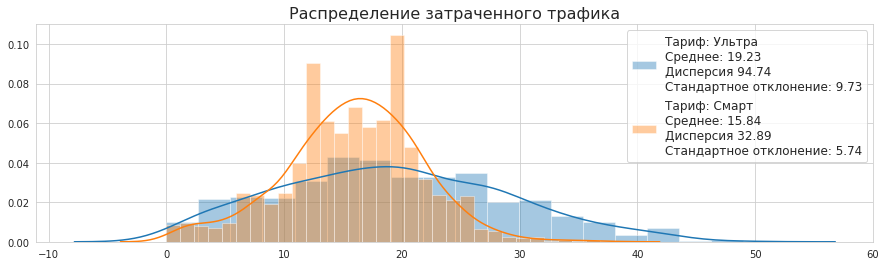

In [46]:
compare_dist(df, 'gb_used', title='Распределение затраченного трафика')

Распределение трафика нормально. Среднее у тарифа Смарт находится выше чем тарифное значение, здесь компания получает доролнительный доход при превышении тарифных значений.


>**_<span style="color:green">Отличная работа с визуализациями, браво! С точки зрения стиля и решения нашей задачи сравнения двух тарифов, построить гистограммы с наложением друг на друга — лучшее решение. </span>_**
>


## Структура доходов внутри тарифа

In [47]:
def add_cost(row, liter='m'):
    #заводим переменную с выручкой
    total_revenue = 0
    #выясняем на каком тарифе наш пользователь
    user_tariff = row.tariff
    #подтягиваем информацию по тарифу
    tariff_info = tariffs.query('tariff_name == @user_tariff')
    #считаем надбавленную выручку
    if liter == 'm':
        total_revenue = float((row.messages_number - tariff_info.messages_included) * tariff_info.rub_per_message)
    elif liter == 'd':
        total_revenue = float((row.calls_duration - tariff_info.minutes_included) * tariff_info.rub_per_minute)
    elif liter == 'g':
        total_revenue = float((row.gb_used - (tariff_info.mb_per_month_included / 1024)) * tariff_info.rub_per_gb)
    if total_revenue > 0:
        return total_revenue
    else:
        return 0    

In [48]:
sample = df.query('revenue > 0')[['tariff', 'messages_number', 'gb_used', 'calls_duration']]

In [49]:
sample = sample.assign(month_fee = sample.tariff.apply(lambda x: 550 if x == 'smart' else 1950),
                       messages_costs = sample.apply(add_cost, args=('m'), axis=1),
                       calls_costs = sample.apply(add_cost, args=('d'), axis=1),
                       internet_costs = sample.apply(add_cost, args=('g'), axis=1))

In [50]:
test = (sample
 .pivot_table(index='tariff', 
              aggfunc={'month_fee' : 'sum', 'messages_costs' : 'sum', 'calls_costs' : 'sum', 'internet_costs' : 'sum'})).T

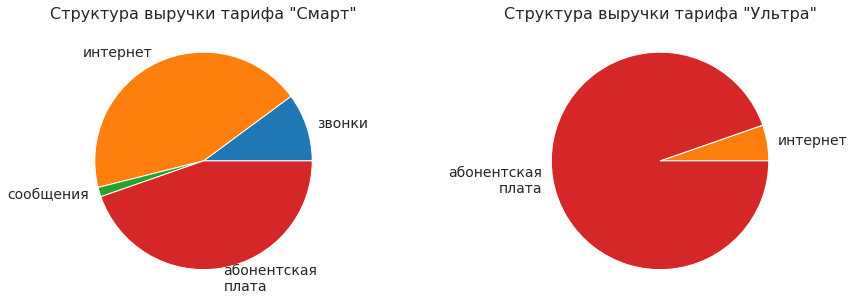

In [51]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121, aspect='equal', title='wadwadaw', ylabel='')
test.plot(kind='pie', y='smart', figsize=(15,5), legend=False, labels=['звонки', 'интернет', 'сообщения', 'абонентская\nплата'],
                  fontsize=14, ax=ax1)
ax1.set_ylabel('')
ax1.set_title('Структура выручки тарифа "Смарт"', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
test.plot(kind='pie', y='ultra', figsize=(15,5), legend=False, labels=['звонки', 'интернет', 'сообщения', 'абонентская\nплата'],
                  fontsize=14, ax=ax2)
ax2.set_ylabel('')
ax2.set_title('Структура выручки тарифа "Ультра"', fontdict={'fontsize': 16})
plt.show()

Согласно данным графикам большая часть выручки идет от абонентской платы. Но тариф смарт хорошо добирает интернетом и звонками, даже есть видимый процент кому не хватает соощений! А вот абоненты тарифа ультра крайне редко превышают лимиты и вся выручка идет только за счет абонентской платы.


>**_<span style="color:red">~~Здесь всё отлично, но нужно добавить развернутый вывод к этому блоку, где нужно перечислить сколько в среднем тратят минут звонков, сообщений и интернет трафика пользователи двух тарифов.~~ </span>_**
>


В среднем пользователи тарифа "Смарт" разговаривают <b>419,44</b> минут, тарифное количество бесплатных минут - 500. У пользователей тарифа "Ультра" среднее время разговора <b>547,76</b> минут. Немного больше чем у пользователей "Смарта" и намного меньше тарфиного значение в 3000 минут. Сообщений польщователи обоих тарифов отправляют немного: <b>38,72</b> сообщения у пользователей "Смарта" и <b>61,16</b> у пользователей "Ультры". И если пользователи "Смарта" хоть немного близки к тарифному количеству сообщений в 50 штук, то пользователи "Ультры" даже не близки к 1000. Интернет более востребованная услуга. В среднем пользователям тарифа "Смарт" нужно <b>15,84</b> гб трафика. Это немного превышает тарифное значение и позволяет комании заработать дополнительные деньги, что видно на графике структуры выручки тарифов. У пользователей "Ультры" среднее значение использования трафика <b>19,23</b> гб. Они нечасто превышают тарифный лимит в 30 гб.

## Проверка гипотез

### Сравнение выручки по двум тарифам

Я считаю, что выборка из 500 пользователей достаточно большая и хорошо представляет генеральную совокупность, поэтому 5% вероятность достаточно мала чтобы подтверждать или отвергать гипотезы. У нас реальные данные для которых такой уровень значимости вполне достаточен. Установим уровень критической значимости в 5%. При превышении этого значения у нас не будет оснований отвергать нулевую гипотезу.

In [52]:
alpha = 0.05

In [53]:
sample1 = df[(df['tariff'] == 'ultra') & (df['revenue'] != 0)].revenue
sample2 = df[(df['tariff'] == 'smart') & (df['revenue'] != 0)].revenue

Выше на графиках было заметно насколько различается выручка от разных тарифов. Проверим можно ли оплучить такую разницу случайно. Нулевая гипотеза: средняя выручка двух тарифов равна. 

In [54]:
results = st.ttest_ind(sample1, sample2)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.3487021576957428e-191
Отвергаем нулевую гипотезу


По результатм т-теста подтвердить нулевую гипотезу не смогли. Поэтому делаем вывод, что два тарифа действительно приносят разную выручку для компании. И тариф Смарт приносит больше.

### Сравнение выручки пользователей из Москвы и других регионов

In [55]:
sample = df.pivot_table(index='user_id', aggfunc={'revenue' : 'sum'}).reset_index()

In [56]:
sample = sample.merge(users[['user_id', 'city']], on='user_id')

Посмотрим как есть ли различия между клиентами из Москвы и других регионов. Нулевая гипотеза: средняя выручка пользователей Москвы и пользователей других регионов равна.

In [57]:
results = st.ttest_ind(sample.query('city == "Москва"').revenue,
                       sample.query('city != "Москва"').revenue)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6389686840596833
Не получилось отвергнуть нулевую гипотезу


По результатам т-теста отвергнуть нулевую гипотезу нет оснований. Получается, что регион не имеет значения когда мы говорим о средней выручке.


>**_<span style="color:green">С проверкой и формулировкой гипотез у тебя полный порядок, но в задании также требовалось обосновать выбор статистического критерия. Добавь, пожалуйста. </span>_**
>


# Заключение

В ходе работы мы оценили выборку пользователей двух тарифов, с целью понять кто приносит больше денег в компанию. 
Подведем итог:
- Количество пользовотелей расло с каждым месяцем, быстрее и больше росло количество более дешевого тарифа "Смарт"
- Средняя продолжительность звонков по тарифам также росла каждый месяц. Связано это в первую очередь с наплывом новых пользователей.
- Среднее количество продолжительности звонков, количества сообщений и использования интернета у пользователей обоих тарифов меньше пороговых значений и сравнимы. Хотя сами пороговые значение существенно отличаются. 
- Исходя из предидущего пункта можно увеличить количество минут, сообщений и интернета без особой нагрузки на оборудование, и использовать это в маркетинговой стратегии.
- В структуре выручки обоих тарифов преобладают абонентская плата и интернет. 
- Выручка от тарифа "Смарт" существенно больше чем от тарифа "Ультра". Результаты тестов показали, что получить такую разницу в выручке случайно крайне маловероятно.
- Тесты также показали, что выручка от столичных пользователей не отличается от регинальных. Но стоит сделать замечание, что выборки совсем неодинаковы. Пользователей из Москвы всего 99, тогда как из Регионов 401.
Учитывая все факторы я бы предложил продвигать тариф "Смарт", он приносит больше денег компании.

>**Спасибо тебе за сдачу твоего проекта. Работа получилась просто замечательная и хорошо структурированная. Видно, что ты отлично справился с материалами спринта и уверенно применяешь полученные навыки на практике. Для зачёта проекта тебе осталось совсем чуть-чуть поработать и исправить ряд некритичных недочётов.**
>
>**Отдельно хочу тебя похвалить за твой комплексный подход к оформлению проекта, твой чистый код и твою отличную работу с визуализациями. Продолжай и дальше совершенствовать эти крайне важные скиллы в своих следующих работах.**
>
>**Буду ждать твой доделанный проект на повторную проверку. Успехов!**
>
>**Update: Привет еще раз! Спасибо тебе за оперативную работу над ошибками. Теперь всё отлично, и проект будет зачтен. Поздравляю! :)**